In [1]:
import os
import ee
import datetime

import numpy as np
import pandas as pd
import rsfuncs as rs
import geopandas as gp

from tqdm import tqdm
from shapely.geometry import Point,Polygon

ee.Initialize()


In [2]:
def get_ims(dataset, startdate,enddate, area, return_dates = False, table = False, monthly_mean = False,  monthly_sum = False):

    '''
    Returns gridded images for EE datasets 
    '''

    if monthly_mean:
        if monthly_sum:
            raise ValueError("cannot perform mean and sum reduction at the same time")              

    ImageCollection = dataset[0]
    var = dataset[1]
    scaling_factor = dataset[2]
    native_res = dataset[3]
    start = ee.Date.fromYMD(startdate.year,startdate.month,startdate.day)
    end = ee.Date.fromYMD(enddate.year,enddate.month,enddate.day)
    
    im1 = ee.ImageCollection(ImageCollection).select(var).filterDate(start, end).mean().set('system:time_start', end.millis())
    im = ee.ImageCollection(im1)
    result = im.getRegion(area,native_res,"epsg:4326").getInfo()

    header, data = im[0], im[1:]

    df = pd.DataFrame(np.column_stack(data).T, columns = header)
    df.latitude = pd.to_numeric(df.latitude)
    df.longitude = pd.to_numeric(df.longitude)
    df[var] = pd.to_numeric(df[var])

    return df

def df_from_ee_object(imcol):
    df = pd.DataFrame(imcol, columns = imcol[0])
    df = df[1:]
    return(df)

def array_from_df(df, variable):
    
    # get data from df as arrays
    lons = np.array(df.longitude)
    lats = np.array(df.latitude)
    data = np.array(df[variable]) # Set var here 
                                              
    # get the unique coordinates
    uniqueLats = np.unique(lats)
    uniqueLons = np.unique(lons)

    # get number of columns and rows from coordinates
    ncols = len(uniqueLons)    
    nrows = len(uniqueLats)

    # determine pixelsizes
    ys = uniqueLats[1] - uniqueLats[0] 
    xs = uniqueLons[1] - uniqueLons[0]

    # create an array with dimensions of image
    arr = np.zeros([nrows, ncols], np.float32)

    # fill the array with values
    counter =0
    for y in range(0,len(arr),1):
        for x in range(0,len(arr[0]),1):
            if lats[counter] == uniqueLats[y] and lons[counter] == uniqueLons[x] and counter < len(lats)-1:
                counter+=1
                arr[len(uniqueLats)-1-y,x] = data[counter] # we start from lower left corner
    
    return arr

def filter_date(product,y,m,d):
    start = ee.Date.fromYMD(y,m,d).advance(-1, "day")
    end = ee.Date.fromYMD(y,m,d)
    prod = product.filterDate(start, end).sort('system:time_start', False).select("ppt")
    return prod

def get_2day_precip(latlon_obj, area):
    res = latlon_obj.reduceRegion(reducer=ee.Reducer.sum(),geometry=area,scale=10)
    data = np.array((ee.Array(res.get("ppt")).getInfo()))
    out = np.array(data)
    return out 


def round_up_to_odd(f):
    f = int(np.ceil(f))
    return f + 1 if f % 2 == 0 else f

In [3]:

# Read teh excel sheet
df = pd.read_excel("/Users/aakash/Desktop/junkyard/ISCN_SOC-DATA_PROFILE_1-1.xlsx")

# filter USA only
df = df[df['country (country)'] == 'United States']
df['date'] = pd.to_datetime(df['observation_date (YYYY-MM-DD)'],errors='coerce')
# drop nans from date, lats, lons, drop alaska
df = df[df['lat (dec. deg)'].notna()]
df = df[df['date'].notna()] 
df = df[df['long (dec. deg)'].notna()]
df = df[df['observation_date (YYYY-MM-DD)'].notna()]
df = df[~df['state (state_province)'].isin(['Alaska','Puerto Rico','American Samoa', 'Northern Mariana Islands','Hawaii'])]

# Make into geodataframe
geometry = [Point(xy) for xy in zip(df['long (dec. deg)'], df['lat (dec. deg)'])]
df = df.drop(['long (dec. deg)','lat (dec. deg)'], axis=1)
gdf = gp.GeoDataFrame(df, crs="EPSG:4326", geometry=geometry)

# load RS data
data = rs.load_data()

# Time step (days)
step = datetime.timedelta(30)

In [4]:
pointList = [(-127.4119140625, 50.36277310359092),
          (-127.4119140625, 23.830272850016865),
          (-63.51542968750001, 23.830272850016865),
          (-63.51542968750001, 50.36277310359092)]

poly = Polygon(pointList)
spoly = gp.GeoSeries([poly],crs=gdf.crs)

usa = gdf[gdf.within(spoly.geometry.iloc[0])]

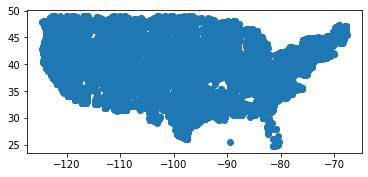

In [5]:
usa.plot()

In [6]:
len(usa)

31301

In [7]:
out = []

In [8]:
# query the (1) NLCD landcover (2) Landsat Bands 1-7 for each site 
   
for idx, row in tqdm(usa[:25].iterrows()):
    
    stid = row['site_name']
            
    # Make geom to submit to EE 
    x,y = row.geometry.buffer(0.0001).envelope.exterior.coords.xy
    coords = [list(zip(x,y))]
    area = ee.Geometry.Polygon(coords)
    
    # Set start/end dates for landsat 
    startdate = row['date'] 
    sd = startdate - step
    enddate = startdate + step
    start = ee.Date.fromYMD(sd.year,sd.month,sd.day)
    end = ee.Date.fromYMD(enddate.year,enddate.month,enddate.day)
    
    date = startdate.strftime("%Y-%m-%d")
    
    # Select the nlcd dataset
    dataset =  rs.load_data()['nlcd']
    ic = dataset[0]
    var = dataset[1]
    res = dataset[3]
    
    # find the nearest nlcd dataset
    col = ic.filterDate(ee.Date(date).advance(-1, 'years'), ee.Date(date).advance(2, 'years')).first()
    if not col.getInfo():
        col = ic.filterDate(ee.Date(date).advance(-3, 'years'), ee.Date(date).advance(2, 'years')).first()
    t = col.reduceRegion(ee.Reducer.frequencyHistogram(), area, res).get(var)
    meta = col.getInfo()
    lc_class = int(list(t.getInfo().keys())[0])
    
    # Get the landcover type
    lcidx = meta['properties']['landcover_class_values'].index(lc_class)
    lctype = meta['properties']['landcover_class_names'][lcidx]
        
    # Get precip data 
    t = filter_date(rs.load_data()['prism_daily'][0], sd.year, sd.month, sd.day).sum()
    precip_total = get_2day_precip(t, area)

    # Landsat - Note: some sites are in the overlap areas between passes.
    # these sites can have multiple obs / day or obs separated by 8days instead of 16. 
    
    if startdate.year > 2013:
        lic = ee.ImageCollection("LANDSAT/LC08/C01/T1_SR")
    elif startdate.year < 2013 and startdate.year > 2000:
        lic = ee.ImageCollection("LANDSAT/LE07/C01/T1_SR")
    elif startdate.year < 2000:
        lic = ee.ImageCollection("LANDSAT/LT05/C01/T1_SR")
    else:
        continue
       
    # scale factor
    lsf = 30

    lstart = ee.Date.fromYMD(startdate.year,startdate.month,startdate.day).advance(-9,"day")
    lend = ee.Date.fromYMD(enddate.year,enddate.month,enddate.day).advance(8, "day")

    l8_col = lic.filterDate(lstart,lend).filterBounds(area).map(rs.mask_quality) # Mask clouds and shadows 
    lt = l8_col.sort('system:time_start')
    lims = lt.toList(lt.size())

    num_ims = len(lims.getInfo())

    ldfs = []

    for i in range(0, num_ims):

        ls_latlon = ee.Image.pixelLonLat().addBands(lims.get(i))
        ltemp = ls_latlon.select(["B1","B2","B3","B4","B5","B6","B7"]).multiply(lsf)
        l8_res = ltemp.reduceRegion(reducer=ee.Reducer.mean(),geometry=area,bestEffort=True,scale=30)

        l8_info_dict = lims.get(i).getInfo()
        l8_date = l8_info_dict['id'][-8:]

        l8_out = l8_res.getInfo()

        ldf = pd.DataFrame.from_dict(l8_out.values()).T
        ldf.columns = l8_out.keys()
        ldf.index = pd.to_datetime([l8_date])
        ldfs.append(ldf)
    
    dfout = row.copy()
    fin_ls = pd.DataFrame(pd.concat(ldfs).mean()).T
    
    df1 = pd.DataFrame(dfout).T
    df2 = pd.DataFrame(fin_ls.mean()).T

    df1.reset_index(drop=True, inplace=True)
    df2.reset_index(drop=True, inplace=True)
    
    outdf = pd.concat([df1,df2], axis = 1)
    outdf['lc_type'] = lctype.split("-")[0]
    outdf['precip'] = precip_total

    out.append(outdf)


25it [00:49,  1.98s/it]


In [9]:
findat = pd.concat(out)

In [10]:
findat

,ISCN 1-1 (2015-12-10),dataset_name_sub,dataset_name_soc,datum (datum),state (state_province),country (country),observation_date (YYYY-MM-DD),site_name,profile_name,profile_zero_ref (profile_zero_ref),...,geometry,B1,B2,B3,B4,B5,B6,B7,lc_type,precip
0,NaN,NRCS Sept/2014,ISCN No SOC stock computation,WGS84,Kansas,United States,1999-08-12,S1999KS067001,00P0082,topO,...,POINT (-101.40242 37.62511),21348.816964,30066.093750,36548.705357,62448.750000,98731.941964,90723.482143,65700.669643,Grassland/Herbaceous,0.000000
0,NaN,NRCS Sept/2014,ISCN No SOC stock computation,WGS84,Texas,United States,1999-10-01,S1999TX409001,00P0116,topO,...,POINT (-97.32553 28.11397),16637.741935,24697.016129,23643.870968,82761.532258,68424.274194,88953.467742,34427.903226,Shrub/Scrub,0.000000
0,NaN,NRCS Sept/2014,ISCN No SOC stock computation,WGS84,Texas,United States,1999-10-01,S1999TX007002,00P0123,topO,...,POINT (-96.8232 28.30639),11417.592593,16953.703704,14284.629630,80713.703704,49227.037037,88767.037037,21606.296296,Emergent Herbaceous Wetlands,0.000000
0,NaN,NRCS Sept/2014,ISCN No SOC stock computation,WGS84,Minnesota,United States,1999-09-28,S1999MN099001,00P0156,topO,...,POINT (-92.54000000000001 43.60122),9045.000000,14190.000000,18330.000000,33195.000000,38520.000000,43185.000000,22830.000000,Grassland/Herbaceous,0.000000
0,NaN,NRCS Sept/2014,ISCN No SOC stock computation,WGS84,Minnesota,United States,1999-09-13,S1999MN039001,00P0158,topO,...,POINT (-92.81610999999999 44.05444),8333.294118,11889.882353,13177.235294,39724.411765,44185.058824,51996.882353,21640.411765,Grassland/Herbaceous,0.000000
0,NaN,NRCS Sept/2014,ISCN No SOC stock computation,WGS84,North Dakota,United States,1999-09-14,S1999ND015001A,00P0196,topO,...,POINT (-100.64214 46.84044),0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,Grassland/Herbaceous,0.000000
0,NaN,NRCS Sept/2014,ISCN No SOC stock computation,WGS84,North Dakota,United States,1999-09-14,S1999ND015002A,00P0197,topO,...,POINT (-100.63975 46.84042),0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,Grassland/Herbaceous,0.000000
0,NaN,NRCS Sept/2014,ISCN No SOC stock computation,WGS84,North Carolina,United States,1999-10-20,99NC087001,00P0231,topO,...,POINT (-83.05598999999999 35.64177),7355.673913,11556.195652,10736.869565,48279.586957,33539.673913,64821.391304,15732.391304,Mixed Forest,0.000000
0,NaN,NRCS Sept/2014,ISCN No SOC stock computation,WGS84,North Carolina,United States,2002-06-13,99NC605 Alarka-OSD,00P0232,topO,...,POINT (-83.35487999999999 35.33372),3290.347826,5246.556522,3543.600000,30862.434783,13890.104348,17579.478261,6751.200000,Deciduous Forest,67.484830
0,NaN,NRCS Sept/2014,ISCN No SOC stock computation,WGS84,Massachusetts,United States,1999-10-26,S1999MA001001,00P0272,topO,...,POINT (-70.03682999999999 41.96875),4310.000000,4662.761905,4283.619048,15814.952381,13060.571429,27810.000000,6210.000000,"Developed, Open Space",1.326337


In [ ]:
findat.to_csv("soc_dat.csv")